In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data_cleanup import *
from feature_selection import *
from model_ import *

from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as rmse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
corr_cols = ['ti_cpi', 'bci_bci', 'ti_cpi_om','vdem_corr', 'vdem_execorr', 'vdem_jucorrdc', 'vdem_pubcorr', 'wbgi_cce']
meta_cols = ['ccode', 'ccode_qog', 'ccodealp', 'ccodealp_year', 'ccodecow', 'cname', 'cname_qog', 'cname_year', 'version', 'year', 'region', 'sub-region']
df = load_reduced_df(corr_cols)

### Feature selection

In [8]:
df = drop_date_columns(df)

best_features_dict = {}
selected_features_dict = {}

for target_col in corr_cols:
    X_train, X_test, y_train, y_test = create_traintestsplit(df, corr_cols = corr_cols, meta_cols=meta_cols, target_col=target_col)
    best_features = pre_select(X_train, y_train)
    best_features = filter_corruption(best_features)
    best_features_dict[target_col] = set(best_features)
    
    selected_features_dict[target_col] = set(filter_highly_correleated(X_train, best_features))




In [9]:
best_features_union=list(set.union(*list(best_features_dict.values())))
best_features_intersection=list(set.intersection(*list(best_features_dict.values())))

best_features_intersection

['wbgi_rle',
 'wbgi_rqe',
 'vdem_libdem',
 'vdem_delibdem',
 'vdem_egaldem',
 'wbgi_gee',
 'fh_cl',
 'wbgi_vae',
 'vdem_egal',
 'vdem_liberal']

In [10]:
selected_features_union=list(set.union(*list(selected_features_dict.values())))
selected_features_intersection=list(set.intersection(*list(selected_features_dict.values())))

selected_features_intersection

['wbgi_rqe', 'vdem_egal', 'wbgi_rle', 'wbgi_vae']

## Modeling

Try Lasso and Random Forest next. Train models for different feature configurations 

    - individual selected features for a particular index
    - union of all good features for all indices
    - intersection of all selected for features for all indices

As scores r2 and rmse are reported. The comparisons are based on r2-scores as they make the scores for different indices comparable.
    

### Lasso
The used library uses cross validation to determine a good value for alpha.

The following script trains for all target indices a Lasso model, then displays r2 score and feature importance information. 

In [11]:
def lasso_info_script(features):
    lasso_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            lasso_bf[target] = apply_lassocv(df, target, list(features[target]), corr_cols, meta_cols, fprint=False)
        else:
            lasso_bf[target] = apply_lassocv(df, target, features, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [lasso_bf[target]['r2'] ,lasso_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [lasso_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [lasso_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)
    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()


First we apply the script for the individually selected features for each corruption index.

scores


,r2,rmse
ti_cpi,0.876727,36.317702
bci_bci,0.642932,72.583941
ti_cpi_om,0.768719,0.796877
vdem_corr,0.661552,0.027649
vdem_execorr,0.611718,0.032013
vdem_jucorrdc,0.336257,0.443047
vdem_pubcorr,0.679769,0.02613
wbgi_cce,0.850515,0.123114


feature importance


,wbgi_rle,wbgi_pve,vdem_polyarchy,wbgi_rqe,wbgi_vae,vdem_egal,vdem_liberal,ihme_lifexp_0104t,ihme_lifexp_0104m
ti_cpi,0.910303,0.034292,0.0,0.0,0.031641,0.023763,NaN,NaN,NaN
bci_bci,0.774493,0.0,NaN,0.0,0.147483,0.0,0.067083,0.0,0.01094
ti_cpi_om,0.829606,0.0,0.042787,0.074544,0.0,0.053063,NaN,NaN,NaN
vdem_corr,0.536211,0.030285,0.15119,0.090273,0.056999,0.135044,NaN,NaN,NaN
vdem_execorr,0.556384,NaN,0.217812,0.0,0.0,0.225804,NaN,NaN,NaN
vdem_jucorrdc,0.794511,0.004627,0.081886,0.0,0.10812,0.010855,NaN,NaN,NaN
vdem_pubcorr,0.453935,0.030008,0.242106,0.0,0.1117,0.16225,NaN,NaN,NaN
wbgi_cce,0.941631,0.019651,0.0,0.0,0.037157,0.00156,NaN,NaN,NaN



feature importance rank


,wbgi_rle,wbgi_pve,vdem_polyarchy,wbgi_rqe,wbgi_vae,vdem_egal,vdem_liberal,ihme_lifexp_0104t,ihme_lifexp_0104m
ti_cpi,1,2,<NA>,<NA>,3,4,<NA>,<NA>,<NA>
bci_bci,1,<NA>,<NA>,<NA>,2,<NA>,3,<NA>,4
ti_cpi_om,1,<NA>,4,2,<NA>,3,<NA>,<NA>,<NA>
vdem_corr,1,6,2,4,5,3,<NA>,<NA>,<NA>
vdem_execorr,1,<NA>,3,<NA>,<NA>,2,<NA>,<NA>,<NA>
vdem_jucorrdc,1,5,3,<NA>,2,4,<NA>,<NA>,<NA>
vdem_pubcorr,1,5,2,<NA>,4,3,<NA>,<NA>,<NA>
wbgi_cce,1,3,<NA>,<NA>,2,4,<NA>,<NA>,<NA>


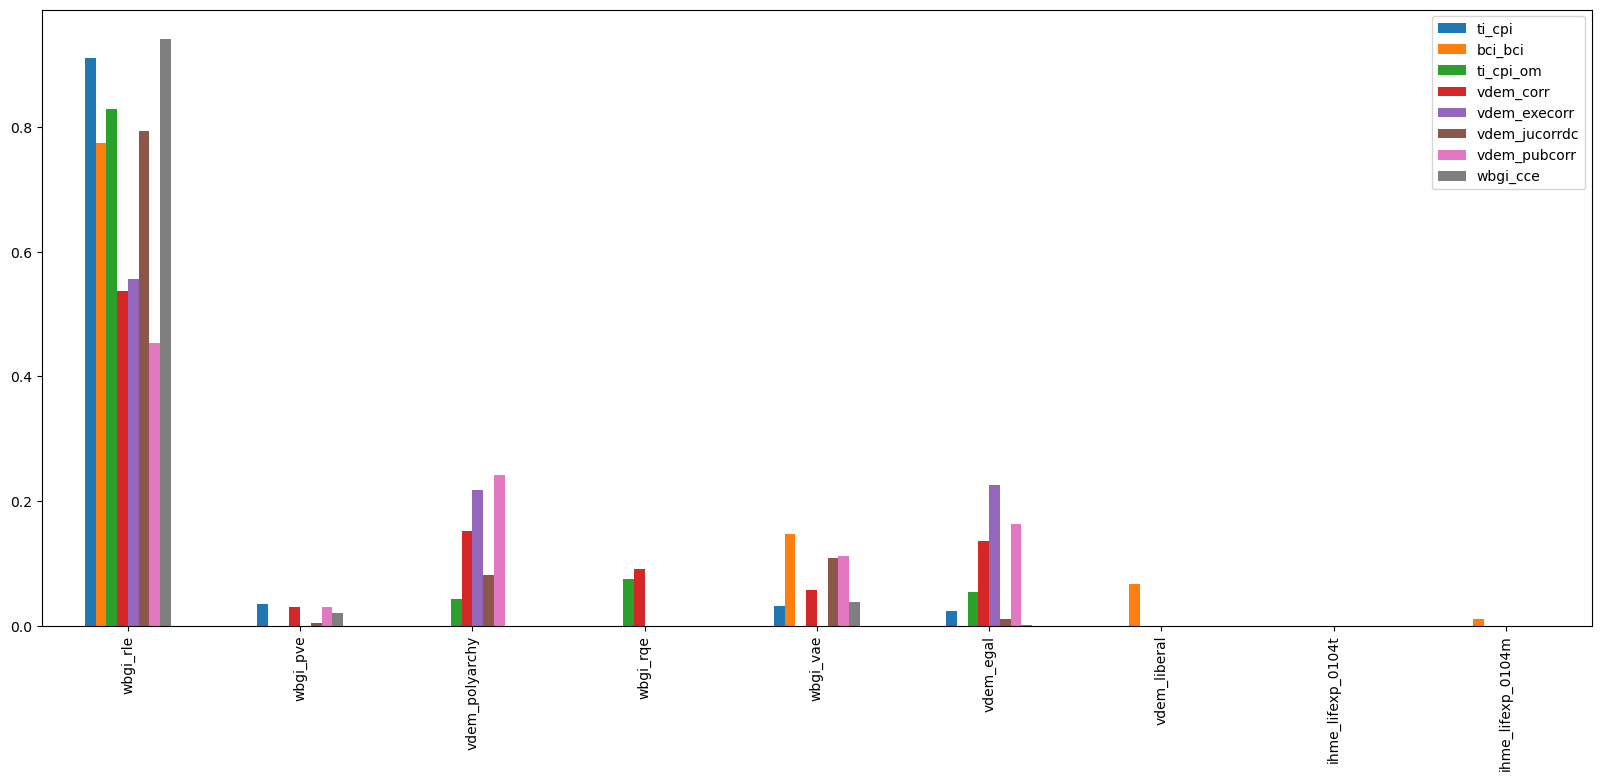

In [12]:
lasso_info_script(selected_features_dict)

Next we use for all corruption indices the same set of features - the set of all as promising declared features.

scores


,r2,rmse
ti_cpi,0.889824,32.45931
bci_bci,0.692608,62.48596
ti_cpi_om,0.82754,0.59421
vdem_corr,0.682901,0.025905
vdem_execorr,0.614808,0.031758
vdem_jucorrdc,0.455833,0.36323
vdem_pubcorr,0.684243,0.025765
wbgi_cce,0.876067,0.10207


feature importance


,fh_pr,ihme_hle_0104t,ihme_hle_0104m,vdem_partipdem,vdem_egaldem,wbgi_gee,wbgi_vae,vdem_egal,vdem_liberal,vdem_edcomp_thick,...,ihme_lifexp_0104t,ihme_lifexp_0104m,wbgi_rle,wbgi_pve,vdem_polyarchy,vdem_libdem,vdem_delibdem,wbgi_rqe,fh_cl,fh_status
ti_cpi,0.003377,0.0,0.0,0.020424,0.066399,0.164519,0.064442,0.0,0.005916,0.0,...,0.0,0.071064,0.391406,0.024862,0.0,0.0,0.0,0.017677,0.040289,0.011471
bci_bci,0.0,0.0,0.0,0.0,0.0,0.223958,0.0,0.0,0.0,0.0,...,0.0,0.046059,0.470903,0.0,0.057408,0.0,0.0,0.016288,0.073535,0.051539
ti_cpi_om,0.0,0.0,0.0,0.0,0.0,0.441777,0.0,0.01336,0.015818,0.0,...,0.0,0.0,0.474423,0.003913,0.0,0.0,0.0,0.0,0.0,0.050708
vdem_corr,0.010163,0.0,0.0,0.104276,0.0,0.129038,0.0,0.049188,0.0,0.0,...,0.0,0.0,0.121761,0.025438,0.06794,0.353826,0.018766,0.062932,0.039979,0.0
vdem_execorr,0.0,0.0,0.0,0.0,0.0,0.192966,0.0,0.119573,0.182262,0.0,...,0.0,0.0,0.223081,0.011876,0.0,0.183447,0.0,0.0,0.086796,0.0
vdem_jucorrdc,0.021337,0.017667,0.0,0.037159,0.0,0.058807,0.07373,0.011935,0.002276,0.085215,...,0.0,0.003781,0.073623,0.004974,0.193673,0.266233,0.057081,0.038879,0.039391,0.00603
vdem_pubcorr,0.0,0.000644,0.0,0.0,0.0,0.242323,0.017414,0.117206,0.065063,0.0,...,0.0,0.036366,0.152192,0.051134,0.0,0.226037,0.0,0.034745,0.055552,0.0
wbgi_cce,0.0,0.0,0.0,0.0,0.014645,0.26674,0.050439,0.0,0.0,0.0,...,0.0,0.038111,0.429879,0.021564,0.0,0.009626,0.0,0.060435,0.019563,0.018632



feature importance rank


,fh_pr,ihme_hle_0104t,ihme_hle_0104m,vdem_partipdem,vdem_egaldem,wbgi_gee,wbgi_vae,vdem_egal,vdem_liberal,vdem_edcomp_thick,...,ihme_lifexp_0104t,ihme_lifexp_0104m,wbgi_rle,wbgi_pve,vdem_polyarchy,vdem_libdem,vdem_delibdem,wbgi_rqe,fh_cl,fh_status
ti_cpi,13,<NA>,<NA>,9,5,2,6,<NA>,12,<NA>,...,<NA>,4,1,8,<NA>,<NA>,<NA>,10,7,11
bci_bci,<NA>,<NA>,<NA>,<NA>,<NA>,2,<NA>,<NA>,<NA>,<NA>,...,<NA>,7,1,<NA>,5,<NA>,<NA>,8,3,6
ti_cpi_om,<NA>,<NA>,<NA>,<NA>,<NA>,2,<NA>,5,4,<NA>,...,<NA>,<NA>,1,6,<NA>,<NA>,<NA>,<NA>,<NA>,3
vdem_corr,12,<NA>,<NA>,4,<NA>,2,<NA>,7,<NA>,<NA>,...,<NA>,<NA>,3,9,5,1,10,6,8,<NA>
vdem_execorr,<NA>,<NA>,<NA>,<NA>,<NA>,2,<NA>,5,4,<NA>,...,<NA>,<NA>,1,7,<NA>,3,<NA>,<NA>,6,<NA>
vdem_jucorrdc,11,12,<NA>,10,<NA>,6,4,13,18,3,...,<NA>,17,5,16,2,1,7,9,8,15
vdem_pubcorr,<NA>,12,<NA>,<NA>,<NA>,1,10,4,5,<NA>,...,<NA>,8,3,7,<NA>,2,<NA>,9,6,<NA>
wbgi_cce,<NA>,<NA>,<NA>,<NA>,10,2,5,<NA>,<NA>,<NA>,...,<NA>,6,1,7,<NA>,11,<NA>,4,8,9


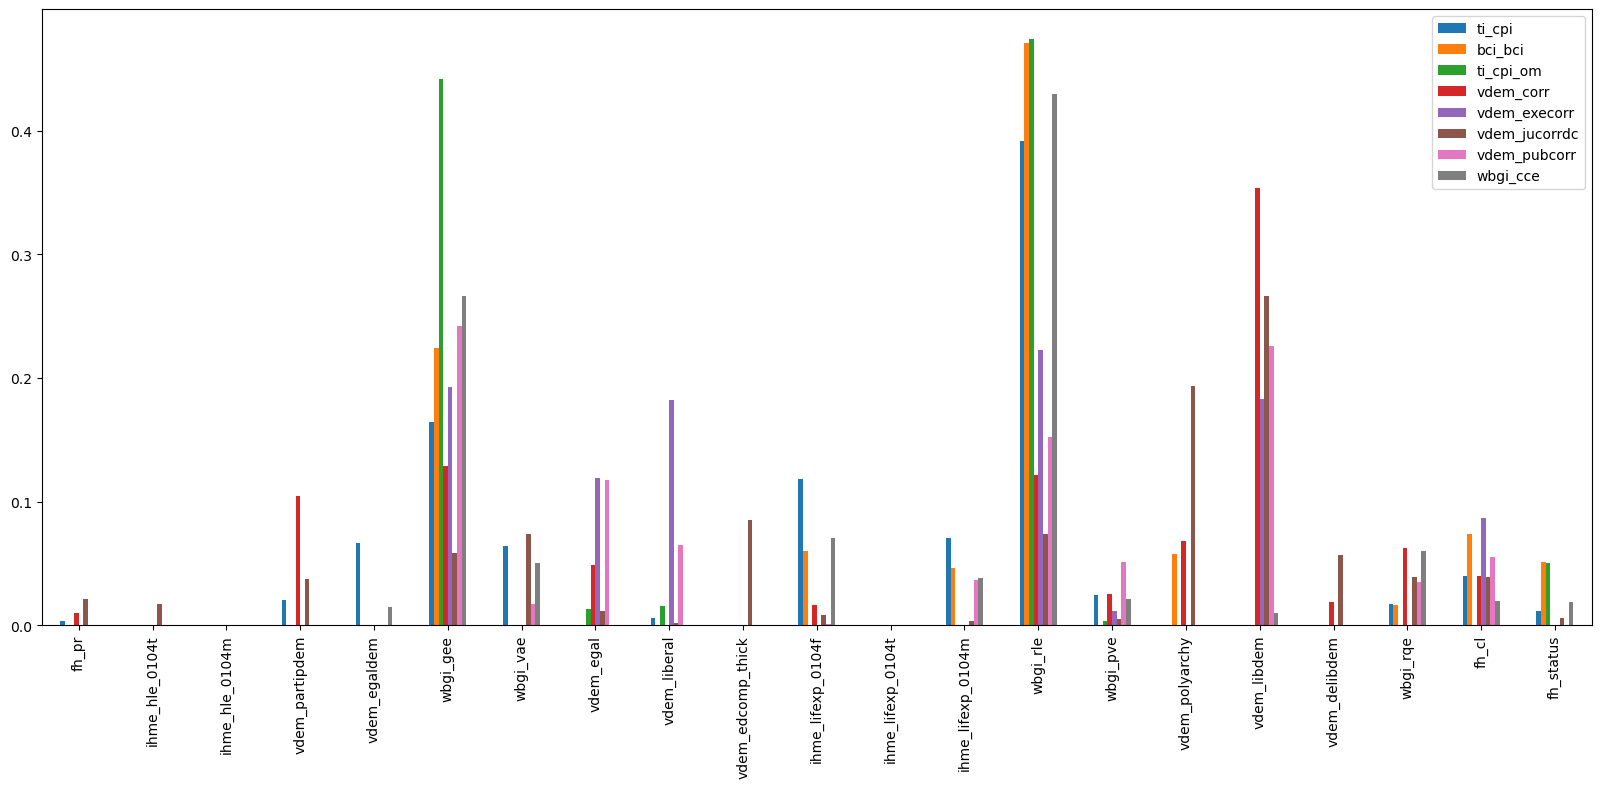

In [13]:
lasso_info_script(best_features_union)

Now we use only the features that are in all individually selected feature sets.

scores


,r2,rmse
ti_cpi,0.873281,37.332838
bci_bci,0.640982,72.980402
ti_cpi_om,0.764842,0.810234
vdem_corr,0.652703,0.028372
vdem_execorr,0.602051,0.03281
vdem_jucorrdc,0.332037,0.445864
vdem_pubcorr,0.68491,0.02571
wbgi_cce,0.848414,0.124844


feature importance


,wbgi_rqe,vdem_egal,wbgi_rle,wbgi_vae
ti_cpi,0.0,0.029594,0.936553,0.033852
bci_bci,0.0,0.014895,0.772295,0.21281
ti_cpi_om,0.064613,0.065573,0.839438,0.030376
vdem_corr,0.100535,0.186416,0.58769,0.125359
vdem_execorr,0.0,0.266798,0.505465,0.227738
vdem_jucorrdc,0.0,0.023638,0.771163,0.205199
vdem_pubcorr,0.0,0.267266,0.533644,0.19909
wbgi_cce,0.0,0.004764,0.958297,0.036939



feature importance rank


,wbgi_rqe,vdem_egal,wbgi_rle,wbgi_vae
ti_cpi,<NA>,3,1,2
bci_bci,<NA>,3,1,2
ti_cpi_om,3,2,1,4
vdem_corr,4,2,1,3
vdem_execorr,<NA>,2,1,3
vdem_jucorrdc,<NA>,3,1,2
vdem_pubcorr,<NA>,2,1,3
wbgi_cce,<NA>,3,1,2


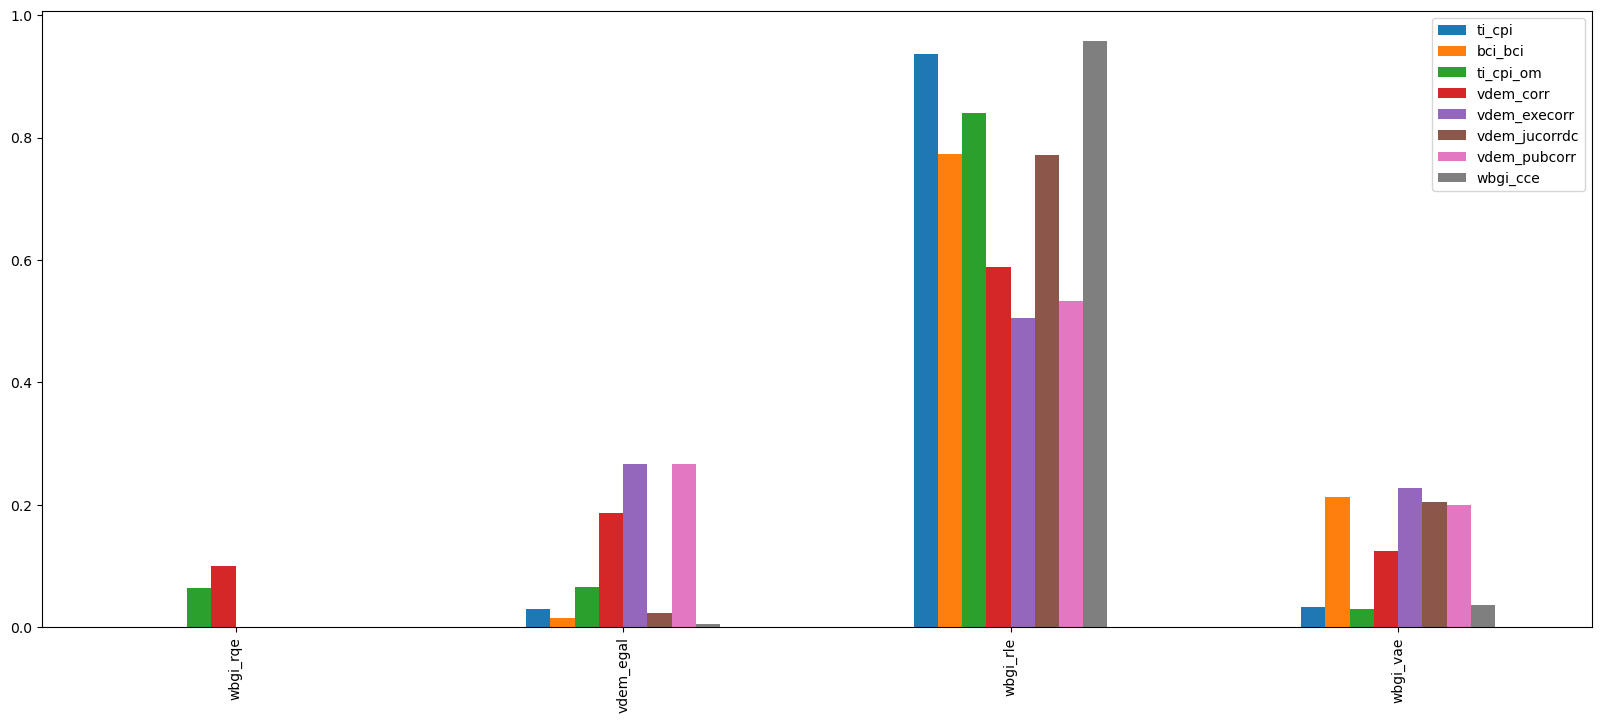

In [14]:
lasso_info_script(selected_features_intersection)

Findings:

- wbgi_rle (Rule of Law) is by far the most important feature in almost all configurations
- most indices behave similarly for the three feature set configuration but
- ti_cpi is most different: its score is very bad with the smallest feature set. Its most important feature is wbgi_pvs [Political Stability and Absence of Violence/Terrorism, Standard error] and not wbgi_rle
- vdem_jucorrdc is also effected more by different feature sets and its score is lower as well in general.
- all the other indices gain information slightly by more features but they do not rely too much on the chosen setups

### Random Forest

Next we do the same for a Random Forest Regressor. Here initially no cross validation is done. We just use a default setup at first.

In [15]:
def rf_info_script(features):
    rf_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_rf(df, target, list(features[target]), corr_cols, meta_cols, fprint=False)
        else:
            rf_bf[target] = apply_rf(df, target, features, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()



First we apply again the script for the individually selected features for each corruption index.

scores


,r2,rmse
ti_cpi,0.877142,36.195436
bci_bci,0.638157,73.55457
ti_cpi_om,0.820431,0.618704
vdem_corr,0.716178,0.023187
vdem_execorr,0.592223,0.03362
vdem_jucorrdc,0.330722,0.446742
vdem_pubcorr,0.639699,0.029399
wbgi_cce,0.855204,0.119252


feature importance


,wbgi_rle,wbgi_pve,vdem_polyarchy,wbgi_rqe,wbgi_vae,vdem_egal,vdem_liberal,ihme_lifexp_0104t,ihme_lifexp_0104m
ti_cpi,0.940803,0.011478,0.010755,0.011735,0.014352,0.010877,NaN,NaN,NaN
bci_bci,0.852599,0.013175,NaN,0.014101,0.028299,0.023595,0.048784,0.009931,0.009515
ti_cpi_om,0.926224,0.009845,0.013098,0.027422,0.013791,0.00962,NaN,NaN,NaN
vdem_corr,0.513779,0.024347,0.050966,0.01834,0.080833,0.311734,NaN,NaN,NaN
vdem_execorr,0.182357,NaN,0.080715,0.039614,0.067227,0.630086,NaN,NaN,NaN
vdem_jucorrdc,0.757966,0.023066,0.042849,0.032135,0.091452,0.052531,NaN,NaN,NaN
vdem_pubcorr,0.500152,0.015723,0.108422,0.021955,0.070349,0.283399,NaN,NaN,NaN
wbgi_cce,0.944396,0.010091,0.010996,0.011006,0.013256,0.010255,NaN,NaN,NaN



feature importance rank


,wbgi_rle,wbgi_pve,vdem_polyarchy,wbgi_rqe,wbgi_vae,vdem_egal,vdem_liberal,ihme_lifexp_0104t,ihme_lifexp_0104m
ti_cpi,1,4,6,3,2,5,<NA>,<NA>,<NA>
bci_bci,1,6,<NA>,5,3,4,2,7,8
ti_cpi_om,1,5,4,2,3,6,<NA>,<NA>,<NA>
vdem_corr,1,5,4,6,3,2,<NA>,<NA>,<NA>
vdem_execorr,2,<NA>,3,5,4,1,<NA>,<NA>,<NA>
vdem_jucorrdc,1,6,4,5,2,3,<NA>,<NA>,<NA>
vdem_pubcorr,1,6,3,5,4,2,<NA>,<NA>,<NA>
wbgi_cce,1,6,4,3,2,5,<NA>,<NA>,<NA>


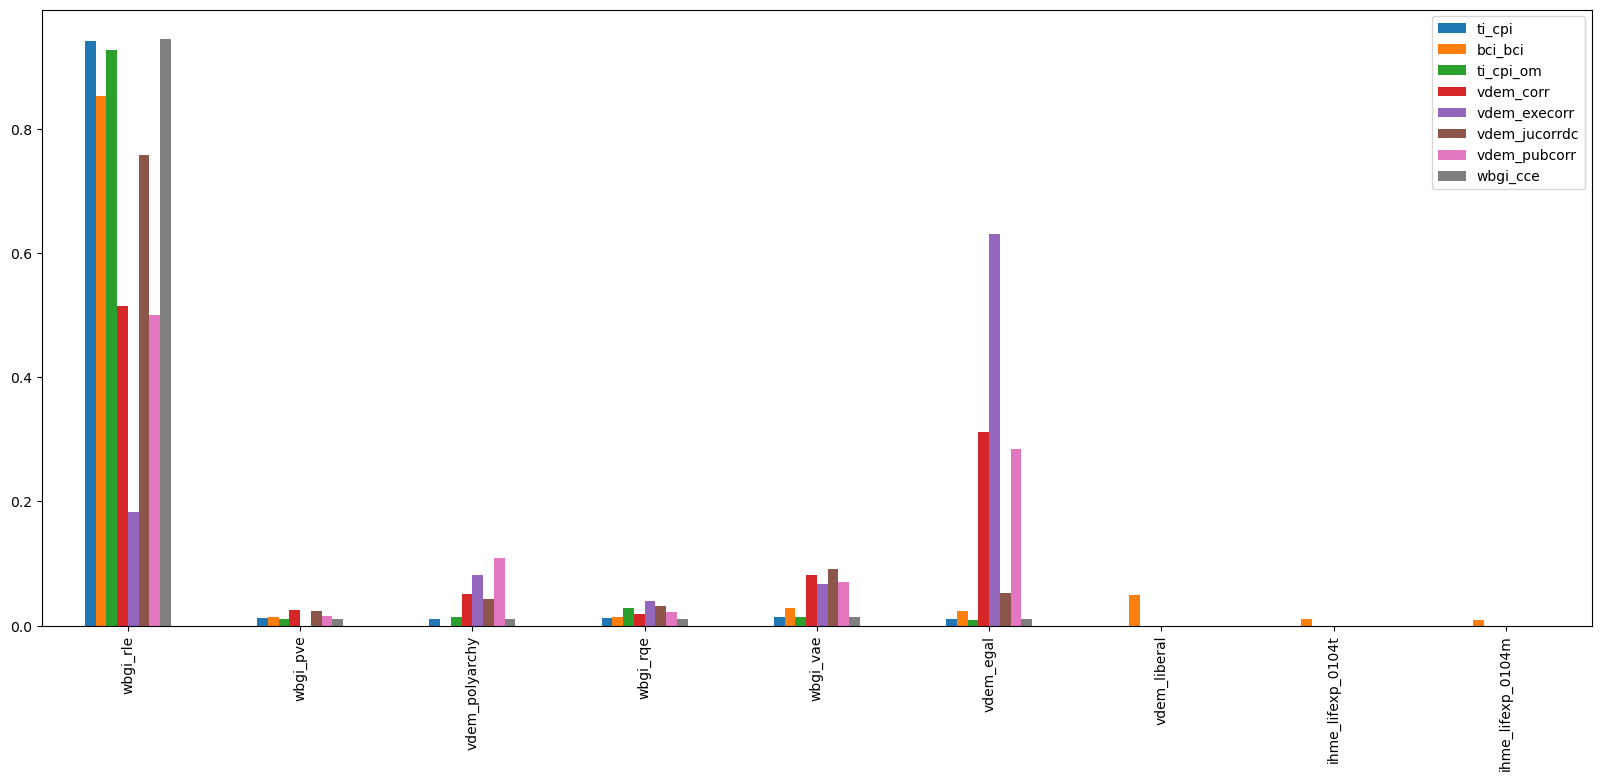

In [16]:
rf_info_script(selected_features_dict)

Next we use for all corruption indices the same set of features - the set of all as promising declared features.

scores


,r2,rmse
ti_cpi,0.891127,32.07518
bci_bci,0.669484,67.186598
ti_cpi_om,0.860575,0.480387
vdem_corr,0.67177,0.026814
vdem_execorr,0.632418,0.030306
vdem_jucorrdc,0.337168,0.442439
vdem_pubcorr,0.644819,0.028982
wbgi_cce,0.861337,0.114202


feature importance


,fh_pr,ihme_hle_0104t,ihme_hle_0104m,vdem_partipdem,vdem_egaldem,wbgi_gee,wbgi_vae,vdem_egal,vdem_liberal,vdem_edcomp_thick,...,ihme_lifexp_0104t,ihme_lifexp_0104m,wbgi_rle,wbgi_pve,vdem_polyarchy,vdem_libdem,vdem_delibdem,wbgi_rqe,fh_cl,fh_status
ti_cpi,0.000284,0.001928,0.001457,0.002649,0.004691,0.028419,0.006728,0.005203,0.001685,0.002414,...,0.001206,0.002009,0.917797,0.00624,0.00163,0.001233,0.005482,0.006078,0.000302,0.000064
bci_bci,0.002077,0.003297,0.003536,0.010635,0.006212,0.365359,0.008349,0.011488,0.011212,0.006191,...,0.002432,0.003081,0.490003,0.008019,0.023419,0.019415,0.009234,0.007679,0.002172,0.000529
ti_cpi_om,0.000497,0.001603,0.001945,0.002645,0.001918,0.361056,0.005231,0.00329,0.002276,0.001837,...,0.001283,0.002376,0.585332,0.00585,0.002043,0.002068,0.003138,0.009657,0.001005,0.000188
vdem_corr,0.001466,0.003381,0.003956,0.007135,0.007858,0.026555,0.018393,0.268989,0.104613,0.010098,...,0.002544,0.005759,0.433145,0.014944,0.008373,0.06258,0.005776,0.006975,0.001047,0.000319
vdem_execorr,0.002245,0.003158,0.004411,0.010748,0.014987,0.043593,0.014004,0.468901,0.167073,0.01437,...,0.002922,0.006406,0.097651,0.013748,0.008409,0.092324,0.016874,0.010198,0.00259,0.000555
vdem_jucorrdc,0.001356,0.005219,0.007251,0.009884,0.007309,0.027215,0.043038,0.022946,0.11394,0.013635,...,0.004375,0.005643,0.684417,0.011686,0.006085,0.011768,0.007473,0.008001,0.001951,0.000326
vdem_pubcorr,0.001414,0.002421,0.003624,0.006586,0.168095,0.152732,0.004413,0.169679,0.058051,0.008493,...,0.002937,0.002818,0.26345,0.015768,0.007237,0.112076,0.005316,0.007322,0.001492,0.000396
wbgi_cce,0.000617,0.001402,0.001392,0.002628,0.002768,0.074724,0.006063,0.004827,0.003114,0.002557,...,0.001146,0.001908,0.874893,0.006901,0.001871,0.002584,0.001797,0.005376,0.000805,0.000212



feature importance rank


,fh_pr,ihme_hle_0104t,ihme_hle_0104m,vdem_partipdem,vdem_egaldem,wbgi_gee,wbgi_vae,vdem_egal,vdem_liberal,vdem_edcomp_thick,...,ihme_lifexp_0104t,ihme_lifexp_0104m,wbgi_rle,wbgi_pve,vdem_polyarchy,vdem_libdem,vdem_delibdem,wbgi_rqe,fh_cl,fh_status
ti_cpi,20,13,16,9,8,2,3,7,14,11,...,18,12,1,4,15,17,6,5,19,21
bci_bci,20,16,15,7,12,2,9,5,6,13,...,18,17,1,10,3,4,8,11,19,21
ti_cpi_om,20,17,14,9,15,2,5,7,11,16,...,18,10,1,4,13,12,8,3,19,21
vdem_corr,19,17,16,11,10,5,6,2,3,8,...,18,15,1,7,9,4,14,12,20,21
vdem_execorr,20,17,16,11,7,5,9,1,2,8,...,18,14,3,10,13,4,6,12,19,21
vdem_jucorrdc,20,17,13,9,12,4,3,5,2,6,...,18,16,1,8,15,7,11,10,19,21
vdem_pubcorr,20,18,15,11,3,4,14,2,6,8,...,16,17,1,7,10,5,13,9,19,21
wbgi_cce,20,16,17,9,8,2,4,6,7,11,...,18,13,1,3,14,10,15,5,19,21


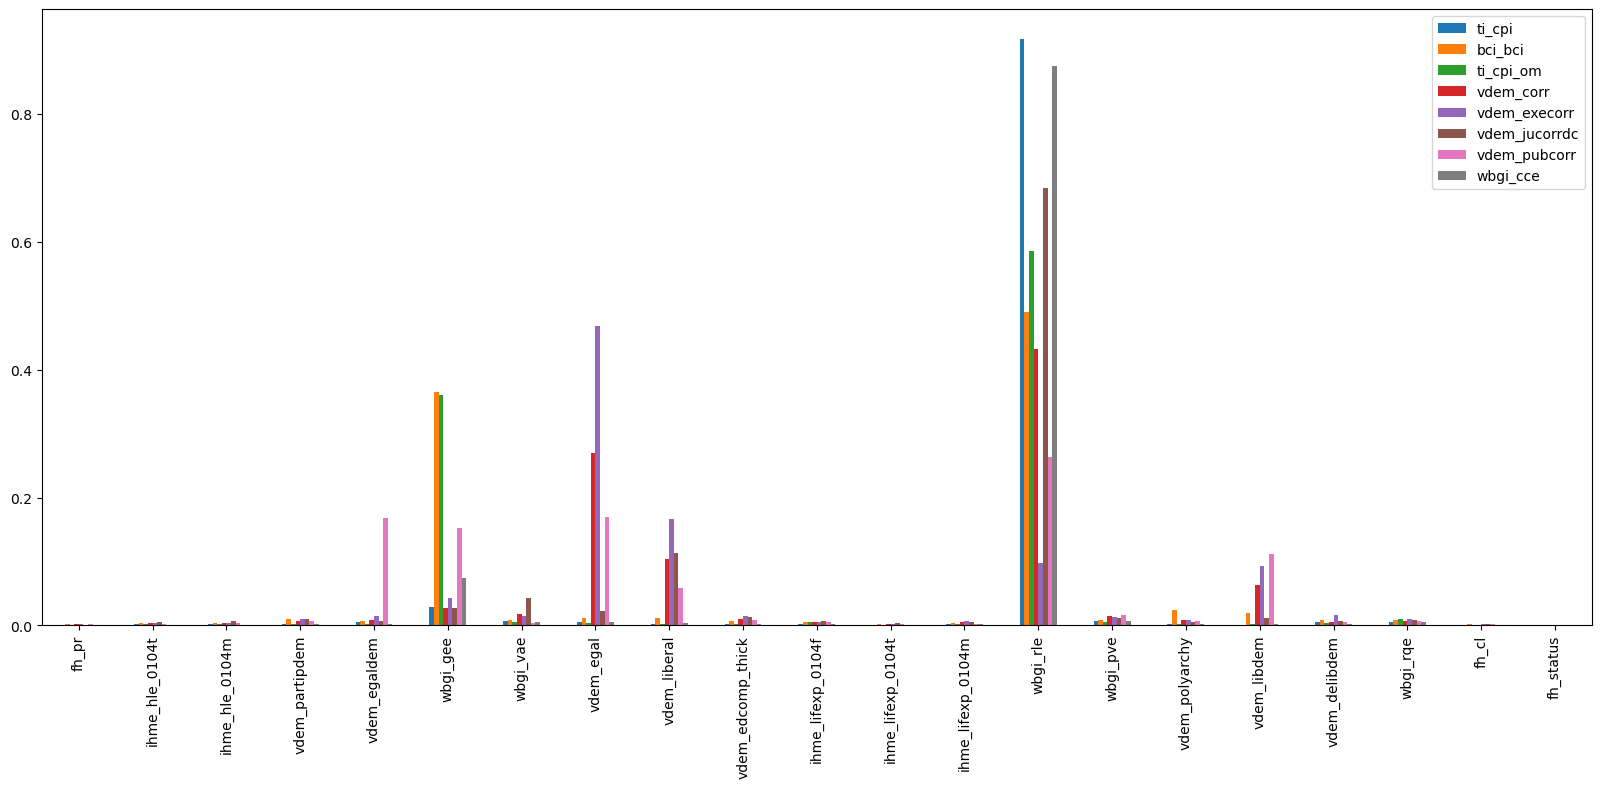

In [17]:
rf_info_script(best_features_union)

Now we use only the features that are in all individually selected feature sets.

scores


,r2,rmse
ti_cpi,0.880695,35.14863
bci_bci,0.631849,74.836873
ti_cpi_om,0.796405,0.701486
vdem_corr,0.653064,0.028343
vdem_execorr,0.577469,0.034836
vdem_jucorrdc,0.283405,0.478326
vdem_pubcorr,0.618558,0.031124
wbgi_cce,0.839156,0.132469


feature importance


,wbgi_rqe,vdem_egal,wbgi_rle,wbgi_vae
ti_cpi,0.017348,0.01582,0.944602,0.02223
bci_bci,0.026094,0.041335,0.865433,0.067137
ti_cpi_om,0.030709,0.017162,0.930514,0.021614
vdem_corr,0.030035,0.330351,0.52963,0.109984
vdem_execorr,0.052689,0.652697,0.197326,0.097289
vdem_jucorrdc,0.043789,0.070253,0.772529,0.113429
vdem_pubcorr,0.035492,0.324363,0.516626,0.123519
wbgi_cce,0.014616,0.016481,0.948882,0.020022



feature importance rank


,wbgi_rqe,vdem_egal,wbgi_rle,wbgi_vae
ti_cpi,3,4,1,2
bci_bci,4,3,1,2
ti_cpi_om,2,4,1,3
vdem_corr,4,2,1,3
vdem_execorr,4,1,2,3
vdem_jucorrdc,4,3,1,2
vdem_pubcorr,4,2,1,3
wbgi_cce,4,3,1,2


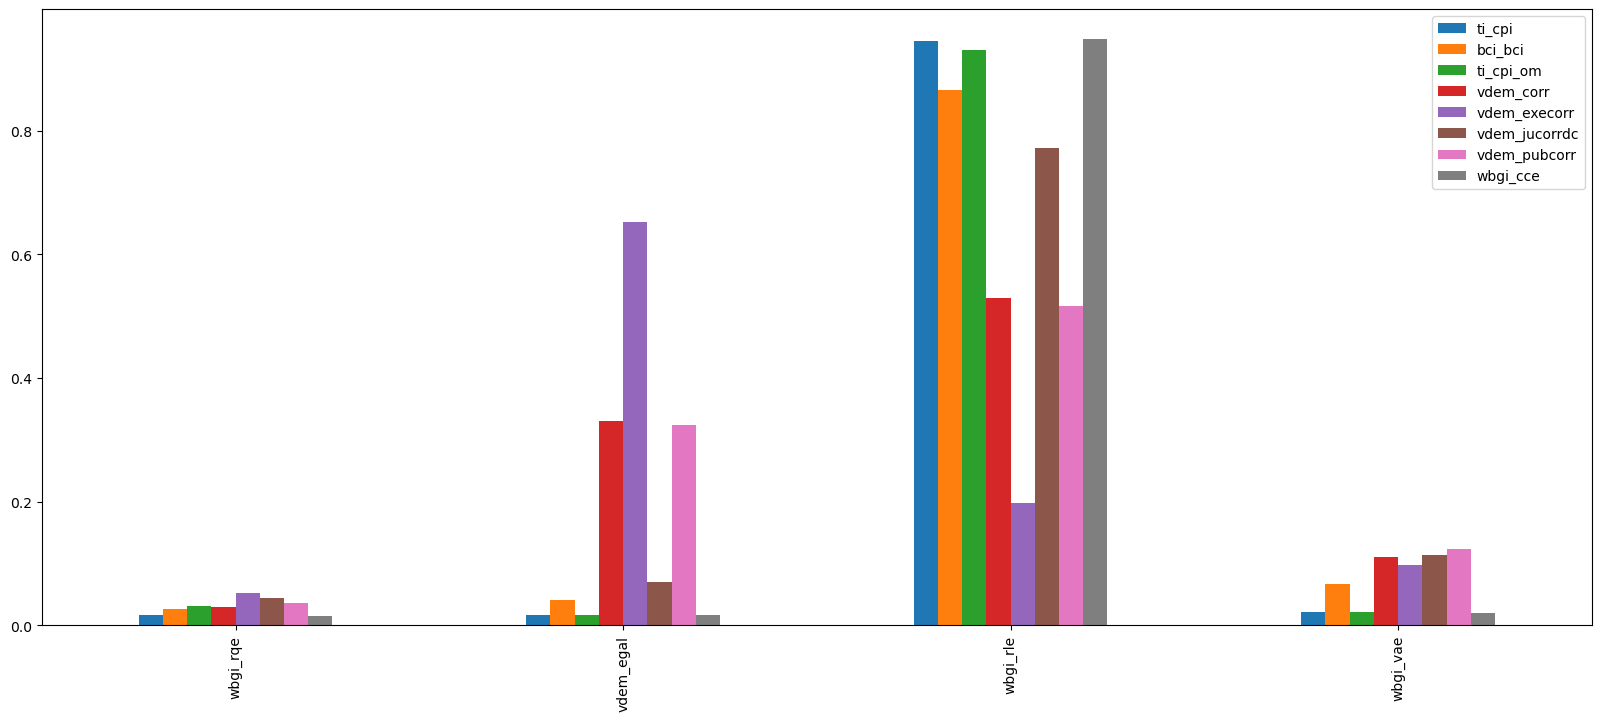

In [18]:
rf_info_script(selected_features_intersection)

The general picture of the results with Random Forest is not that different to the one with Lasso. Some differences are

- ti_cpi is predicted very well now both in comparison with Lasso and with all other indices
- HOWEVER, if only the minimal feature set is used ti_cpi is even worse than with Lasso
- for vdem_execorr the vdem_egal (Egalitarian component index) is the most important feature
- vdem_jucorr is now by far the most difficult to predict index
- although feature importance is not straight-forward comparable between Lasso (weight of coefficients) and Random Forest (Gini) it seems like Random Forst discriminates harder with regard to features

Random Forest performs either similarly or better for most setups / indices allthough no parameter optimization is done by now. So we continue with Random Forst and do hyperparameter optimization for some specific settings next to further optimize the results.

### Grid Search: Random Forest

With cross validation / hyperparameter grid search better parameters are determined. With those optimizations then again models are trained, then the test set is predicted and scores are evaluated.

The script defined below shows a similar report than above.

In [19]:
def rf_gridsearch_info_script(features):
    rf_bf = dict()

    param_grid = {
        "randomforestregressor__max_depth": [2, 3, 5, 10, None],
        "randomforestregressor__min_samples_split": [2, 3, 5, 10],
        "randomforestregressor__max_features": ["log2", None]
        }

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_gridsearch_rf(df, target, list(features[target]), param_grid, corr_cols, meta_cols, fprint=False)
        else:
            rf_bf[target] = apply_gridsearch_rf(df, target, features, param_grid, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)
    rf_bf[target]
    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)
    rf_bf[target]['params']
    l_params = [rf_bf[target]['params'] for target in corr_cols]
    df_params = pd.concat(l_params)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()

    print('params')
    display(df_params)
    print()


Now we only use for each index the individually selected feature set as we saw above that the results are comparable (so the feature selection process works adequately).

In [20]:
rf_gridsearch_info_script(selected_features_dict)

KeyboardInterrupt: 

For most indices the hyperparameter optimization does not seem to significantly improve the r2-scores. But for vdem_jucorrdc it seems to improve. For vdem_pubcorr and wbgi_cce the improvement is minor.

The feature importance (figure) changes a lot more. Here we see for all but bci_bci that relatively wbgi_rle is not as important anymore. This is most likely due to the max_samples_features being log2 now. One could argue if the original model where wbgi_rle is the main feature is simpler and from the same quality or on the other side that other features are also able to replace wbgi_rle when combined.